<a href="https://colab.research.google.com/github/LeeLucky789789/DVR-/blob/main/%E4%B8%80%E7%BB%B4%E5%AF%86%E5%BA%A6%E6%B3%9B%E5%87%BD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Numpy 1D-DFT
- 参考: http://dcwww.camd.dtu.dk/~askhl/files/python-dft-exercises.pdf
- 目标: 写出Kohn-Sham (KS) DFT代码
    - 目标：谐波振荡器，包括动能，电子之间的静电斥力以及电子相互作用的局部密度近似值，而忽略了相关性。
    - 哈密顿量:
    
$$\hat{H}=-\frac{1}{2}\frac{d^2}{dx^2}+v(x)\\
v(x)=v_{Ha}(x)+v_{LDA}(x)+x^2$$

- 我们应该如何做?
    1. 表示哈密顿量
    1. 计算KS波函数和密度。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
sns.set_style("white")

# 微分算符
- 为了表示动力学算子
- 在本部分中，我们是为了表示区分正弦曲线，将其表示为函数跟随网格的函数。

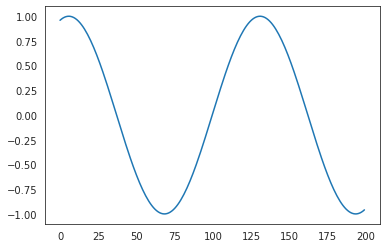

In [3]:
n_grid=200
x=np.linspace(-5,5,n_grid)
y=np.sin(x)
plt.plot(y)

### 一阶微分

- 近似:

$$(\frac{dy}{dx})_{i}=\frac{y_{i+1}-{y_{i}}}{h}$$

- 然后:

$$D_{ij}=\frac{\delta_{i+1,j}-\delta_{i,j}}{h}$$

- 我们可以这样写:

$$(\frac{dy}{dx})_{i}=D_{ij} y_{j}$$


- 在网格的末尾可能无法很好的定义导数.
- $\delta_{ij}$ is Kronecker delta
- Einstein求和用于最后一个整数

In [4]:
h=x[1]-x[0]
D=-np.eye(n_grid)+np.diagflat(np.ones(n_grid-1),1)
D = D / h

### 二阶微分

- 与一阶微分相同:

$$D^2_{ij}=\frac{\delta_{i+1,j}-2\delta_{i,j}+\delta_{i-1,j}}{h^2}$$

- 这可以用一阶写 $D_{ij}$, 如下所示 (注意转置):

$$D^2_{ij}=-D_{ik}D_{jk}$$

- 导数在网格的末尾可能没有很好的定义

In [5]:
D2=D.dot(-D.T)
D2[-1,-1]=D2[0,0]

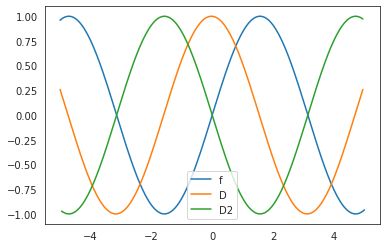

In [6]:
sns.set_style("white")
plt.plot(x,y, label="f")
plt.plot(x[:-1],D.dot(y)[:-1], label="D")
plt.plot(x[1:-1],D2.dot(y)[1:-1], label="D2")
plt.legend()

# 非相互作用电子
- 这是由网格大小给定的盒子中非相互作用自由粒子的哈密顿量:
$$\hat{H} = \hat{T} = - \frac{1}{2} \frac{d^2}{dx^2}$$

- 我们可以按照以下方式求解KS方程：

In [7]:
eig_non, psi_non=np.linalg.eigh(-D2/2)

画图（本征能量写在标签上）

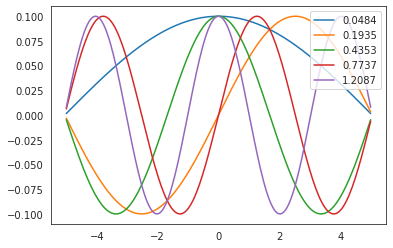

In [8]:
for i in range(5):
    plt.plot(x,psi_non[:,i], label=f"{eig_non[i]:.4f}")
    plt.legend(loc=1)

# 谐振子
- 包括外部电势 $v_{ext}=x^2$:
$$\hat{H} = \hat{T} = - \frac{1}{2} \frac{d^2}{dx^2} + x^2$$

- 我们可以将电势写出矩阵 $X$, 如下所示:

In [9]:
X=np.diagflat(x*x)

解KS方程

In [10]:
eig_harm, psi_harm = np.linalg.eigh(-D2/2+X)

画图

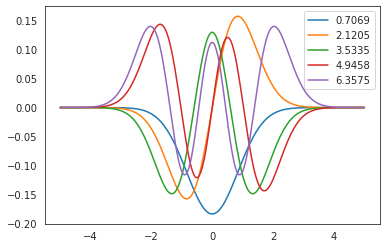

In [11]:
for i in range(5):
    plt.plot(x,psi_harm[:,i], label=f"{eig_harm[i]:.4f}")
    plt.legend(loc=1)

# Well potential


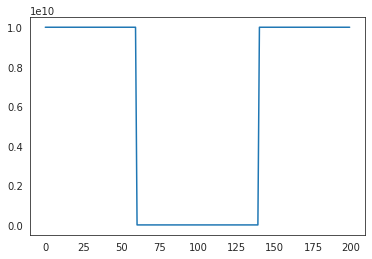

In [12]:
w=np.full_like(x,1e10)
w[np.logical_and(x>-2,x<2)]=0.
plt.plot(w)

解决KS方程

In [13]:
eig_well, psi_well= np.linalg.eigh(-D2/2+np.diagflat(w))

画图

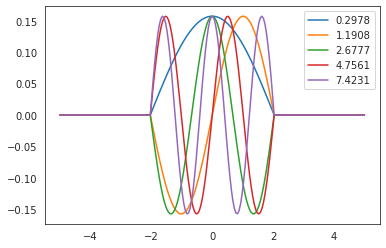

In [14]:
for i in range(5):
    plt.plot(x,psi_well[:,i], label=f"{eig_well[i]:.4f}")
    plt.legend(loc=1)

# 密度
- 我们将要包括库仑或Hatree相互作用以及LDA交换
- 两者都是密度函数
- 因此我们需要计算电子密度
- 每一个态应该归一化:
$$\int \lvert \psi \rvert ^2 dx = 1$$

- 让 $f_n$ 为占有数, 密度 $n(x)$ 可以写成下面形式:
$$n(x)=\sum_n f_n \lvert \psi(x) \rvert ^2 $$

- 注意:
    - 每个状态可以容纳两个电子，一个自旋向上，一个自旋向下。
    - 在DFT中，我们计算基态。

In [15]:
# integral
def integral(x,y,axis=0):
    dx=x[1]-x[0]
    return np.sum(y*dx, axis=axis)

# 电子数

In [16]:
num_electron=17

密度

In [17]:
def get_nx(num_electron, psi, x):
    # normalization
    I=integral(x,psi**2,axis=0)
    normed_psi=psi/np.sqrt(I)[None, :]
    
    # occupation num
    fn=[2 for _ in range(num_electron//2)]
    if num_electron % 2:
        fn.append(1)

    # density
    res=np.zeros_like(normed_psi[:,0])
    for ne, psi  in zip(fn,normed_psi.T):
        res += ne*(psi**2)
    return res

画图

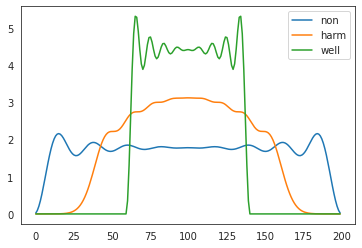

In [18]:
plt.plot(get_nx(num_electron,psi_non, x), label="non")
plt.plot(get_nx(num_electron,psi_harm, x), label="harm")
plt.plot(get_nx(num_electron,psi_well, x), label="well")
plt.legend(loc=1)

# 交换能量
- 考虑LDA中的交换函数:
    - 为了简单起见，忽略相关性.

$$ E_X^{LDA}[n] = -\frac{3}{4} \left(\frac{3}{\pi}\right)^{1/3} \int n^{4/3} dx$$

- 电势由交换能量相对于密度的函数给出:

$$ v_X^{LDA}[n] = \frac{\partial E_X^{LDA}}{\partial n} = - \left(\frac{3}{\pi}\right)^{1/3} n^{1/3}$$

- 代码

In [19]:
def get_exchange(nx,x):
    energy=-3./4.*(3./np.pi)**(1./3.)*integral(x,nx**(4./3.))
    potential=-(3./np.pi)**(1./3.)*nx**(1./3.)
    return energy, potential

# 库仑电势
- 静电能量或Hatree能量
- 3D-Hatree能量在1D没有收敛.
- 因此我们作弊并用如下修改:
$$ E_{Ha}=\frac{1}{2}\iint \frac{n(x)n(x')}{\sqrt{(x-x')^2+\varepsilon}}dxdx'$$

    - 其中 $\varepsilon$是一个小的正常数

- 电势由下面式给出:
$$ v_{Ha}=\int \frac{n(x')}{\sqrt{(x-x')^2+\varepsilon}}dx'$$

- 用矩阵表示:
$$E_{Ha} = \frac{1}{2} \frac{n_in_jh^2}{\sqrt{(x_{i}-x_{j})^2+\varepsilon}}$$
$$v_{Ha, i} = \frac{n_jh}{\sqrt{(x_{i}-x_{j})^2+\varepsilon}}$$

In [20]:
def get_hatree(nx,x, eps=1e-1):
    h=x[1]-x[0]
    energy=np.sum(nx[None,:]*nx[:,None]*h**2/np.sqrt((x[None,:]-x[:,None])**2+eps)/2)
    potential=np.sum(nx[None,:]*h/np.sqrt((x[None,:]-x[:,None])**2+eps),axis=-1)
    return energy, potential

# 解决KS方程：自洽循环
0. 初始化密度（可以取任意常数）
1. 计算交换势和Hatree势
2. 计算哈密顿量
3. 计算波函数和本征值
4. 如果不收敛，计算密度并返回.

In [21]:
def print_log(i,log):
    print(f"step: {i:<5} energy: {log['energy'][-1]:<10.4f} energy_diff: {log['energy_diff'][-1]:.10f}")

In [22]:
max_iter=1000
energy_tolerance=1e-5
log={"energy":[float("inf")], "energy_diff":[float("inf")]}

In [23]:
nx=np.zeros(n_grid)
for i in range(max_iter):
    ex_energy, ex_potential=get_exchange(nx,x)
    ha_energy, ha_potential=get_hatree(nx,x)
    
    # Hamiltonian
    H=-D2/2+np.diagflat(ex_potential+ha_potential+x*x)
    
    energy, psi= np.linalg.eigh(H)
    
    # log
    log["energy"].append(energy[0])
    energy_diff=energy[0]-log["energy"][-2]
    log["energy_diff"].append(energy_diff)
    print_log(i,log)
    
    # convergence
    if abs(energy_diff) < energy_tolerance:
        print("converged!")
        break
    
    # update density
    nx=get_nx(num_electron,psi,x)
else:
    print("not converged")

step: 0     energy: 0.7069     energy_diff: -inf
step: 1     energy: 16.3625    energy_diff: 15.6555321919
step: 2     energy: 13.8021    energy_diff: -2.5603559494
step: 3     energy: 15.3002    energy_diff: 1.4980525863
step: 4     energy: 14.4119    energy_diff: -0.8882287680
step: 5     energy: 14.9470    energy_diff: 0.5350438262
step: 6     energy: 14.6242    energy_diff: -0.3228271880
step: 7     energy: 14.8201    energy_diff: 0.1959328656
step: 8     energy: 14.7011    energy_diff: -0.1190355457
step: 9     energy: 14.7735    energy_diff: 0.0724651058
step: 10    energy: 14.7294    energy_diff: -0.0441312736
step: 11    energy: 14.7563    energy_diff: 0.0268946713
step: 12    energy: 14.7399    energy_diff: -0.0163922405
step: 13    energy: 14.7499    energy_diff: 0.0099933983
step: 14    energy: 14.7438    energy_diff: -0.0060926001
step: 15    energy: 14.7475    energy_diff: 0.0037147279
step: 16    energy: 14.7452    energy_diff: -0.0022649307
step: 17    energy: 14.7466   

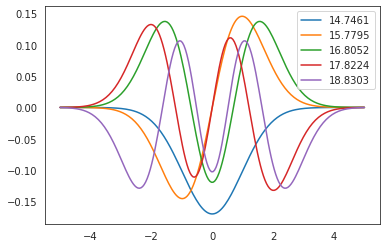

In [24]:
for i in range(5):
    plt.plot(x,psi[:,i], label=f"{energy[i]:.4f}")
    plt.legend(loc=1)

# 将密度与自由粒子进行比较



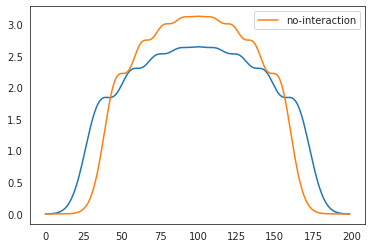

In [25]:
plt.plot(nx)
plt.plot(get_nx(num_electron,psi_harm,x), label="no-interaction")
plt.legend()